In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mostafa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('D:\emails.csv')

In [3]:
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
data.shape

(5728, 2)

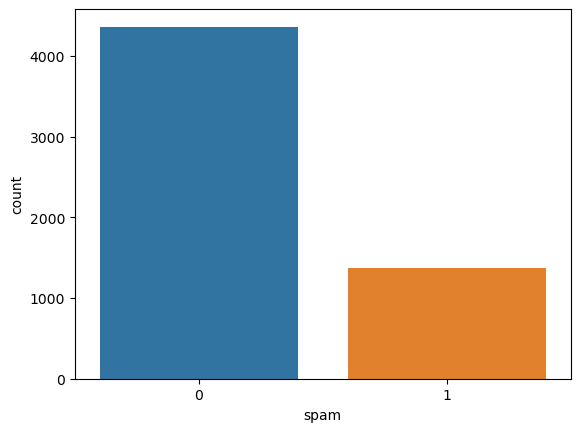

In [5]:
sns.countplot(x='spam',data=data)
plt.show()

In [7]:
data.spam.value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [8]:
ham_msg = data[data.spam == 0 ]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n =len(spam_msg),
                        random_state=42)

In [9]:
spam_msg

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
1363,Subject: are you ready to get it ? hello ! v...,1
1364,Subject: would you like a $ 250 gas card ? do...,1
1365,"Subject: immediate reply needed dear sir , i...",1
1366,Subject: wanna see me get fisted ? fist bang...,1


In [10]:
balanced_data = ham_msg.append(spam_msg)\
    .reset_index(drop=True)

In [11]:
balanced_data

,text,spam
0,Subject: interview schedule for jinbaek kim i...,0
1,"Subject: re : wednesday meeting eric , i thi...",0
2,Subject: re : london research group i ' d do ...,0
3,"Subject: re : congratulations vince , thanks ...",0
4,Subject: osman sezgen steve kromer is request...,0
...,...,...
2731,Subject: are you ready to get it ? hello ! v...,1
2732,Subject: would you like a $ 250 gas card ? do...,1
2733,"Subject: immediate reply needed dear sir , i...",1
2734,Subject: wanna see me get fisted ? fist bang...,1


Text(0.5, 0, 'Message types')

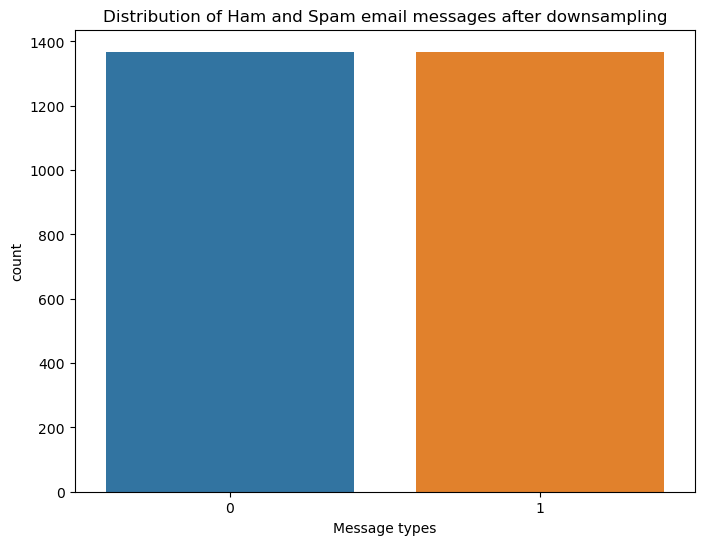

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [14]:
balanced_data.head()

,text,spam
0,Subject: interview schedule for jinbaek kim i...,0
1,"Subject: re : wednesday meeting eric , i thi...",0
2,Subject: re : london research group i ' d do ...,0
3,"Subject: re : congratulations vince , thanks ...",0
4,Subject: osman sezgen steve kromer is request...,0


In [16]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject','')
balanced_data.head()

,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [17]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('','',punctuations_list)
    return text.translate(temp)
balanced_data['text'] = balanced_data['text'].apply(lambda x : remove_punctuations(x))
balanced_data.head()

,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [14]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
        word = word.lower()
 
        if word not in stop_words:
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


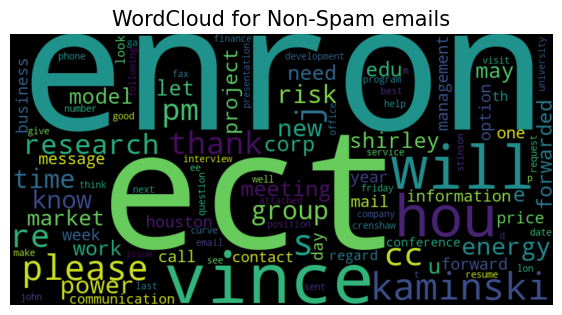

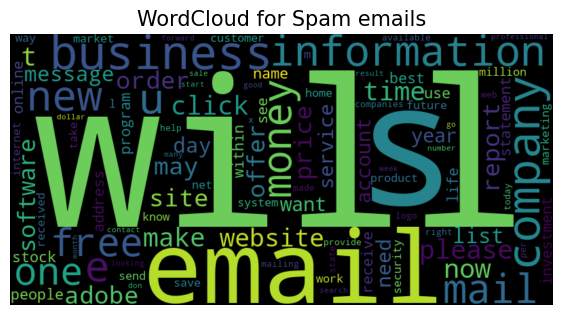

In [18]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

In [19]:
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
 
# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)
 
# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len, 
                                padding='post', 
                                truncating='post')
test_sequences = pad_sequences(test_sequences, 
                               maxlen=max_len, 
                               padding='post', 
                               truncating='post')

In [25]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32, 
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           809664    
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 813377 (3.10 MB)
Trainable params: 813377 (3.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True) ,
             metrics = ['accuracy'],
              optimizer = 'adam')

In [24]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [23]:
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20, 
                    batch_size=32,
                    callbacks = [lr, es])

Epoch 1/20
69/69 [==============================] - 6s 41ms/step - loss: 0.5855 - accuracy: 0.6988 - val_loss: 0.2541 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 2s 31ms/step - loss: 0.1939 - accuracy: 0.9552 - val_loss: 0.1648 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 2s 32ms/step - loss: 0.1450 - accuracy: 0.9634 - val_loss: 0.1196 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 2s 30ms/step - loss: 0.1472 - accuracy: 0.9648 - val_loss: 0.2030 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 2s 30ms/step - loss: 0.0980 - accuracy: 0.9799 - val_loss: 0.1727 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 2s 30ms/step - loss: 0.0777 - accuracy: 0.9845 - val_loss: 0.1618 - val_accuracy: 0.9635 - lr: 5.0000e-04


In [24]:
test_loss , test_accuracy = model.evaluate(test_sequences,test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 [==============================] - 0s 7ms/step - loss: 0.1196 - accuracy: 0.9726
Test Loss : 0.11956720054149628
Test Accuracy : 0.9726277589797974


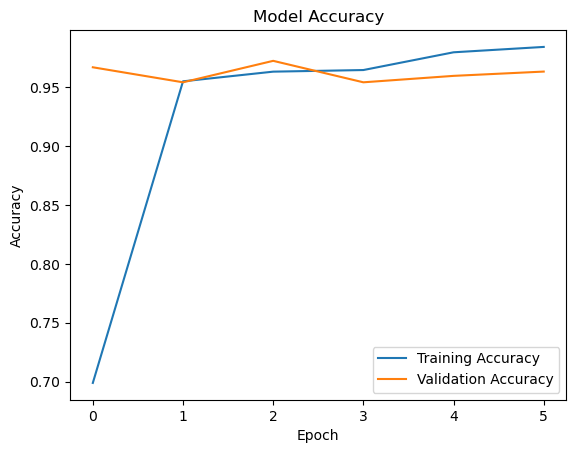

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()